<a href="https://colab.research.google.com/github/bhavyagitub/faculty-assessment/blob/main/Example_on_BRATS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note
- [Colab Only] Means the associated cell is required only if you are running the model on Google Colaboratory

## Mount Drive [Colab Only]
Mount the google drive to access the dataset stored on drive.

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Extract the Dataset

In [ ]:
import zipfile  # For faster extraction
dataset_path = "/gdrive/My Drive/MICCAI_BraTS_2018_Data_Training.zip"  # Replace with your dataset path
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()

## Get required packages
- **SimpleITK**: For loading the dataset
- **[model.py](https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/)**: The model from BRATS2018 winning paper

In [6]:
!pip install simpleitk
!wget https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/raw/master/model.py

--2025-02-03 11:24:05--  https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/raw/master/model.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/master/model.py [following]
--2025-02-03 11:24:05--  https://raw.githubusercontent.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/master/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16490 (16K) [text/plain]
Saving to: ‘model.py.1’

model.py.1          100%[===================>]  1

## Imports and helper functions

In [12]:
import SimpleITK as sitk  # For loading the dataset
import numpy as np  # For data manipulation
from model import build_model  # For creating the model
import glob  # For populating the list of files
from scipy.ndimage import zoom  # For resizing
import re  # For parsing the filenames (to know their modality)

ImportError: cannot import name 'mse' from 'keras.losses' (/usr/local/lib/python3.11/dist-packages/keras/api/losses/__init__.py)

In [14]:
# Keras implementation of the paper:
# 3D MRI Brain Tumor Segmentation Using Autoencoder Regularization
# by Myronenko A. (https://arxiv.org/pdf/1810.11654.pdf)
# Author of this code: Suyog Jadhav (https://github.com/IAmSUyogJadhav)

import keras.backend as K
from tensorflow.keras.losses import MeanSquaredError as mse # Import MeanSquaredError and alias it as 'mse'
from keras.layers import Conv3D, Activation, Add, UpSampling3D, Lambda, Dense
from keras.layers import Input, Reshape, Flatten, Dropout, SpatialDropout3D
from keras.optimizers import adam
from keras.models import Model
try:
    from group_norm import GroupNormalization
except ImportError:
    import urllib.request
    print('Downloading group_norm.py in the current directory...')
    url = 'https://raw.githubusercontent.com/titu1994/Keras-Group-Normalization/master/group_norm.py'
    urllib.request.urlretrieve(url, "group_norm.py")
    from group_norm import GroupNormalization


def green_block(inp, filters, data_format='channels_first', name=None):
    """
    green_block(inp, filters, name=None)
    ------------------------------------
    Implementation of the special residual block used in the paper. The block
    consists of two (GroupNorm --> ReLu --> 3x3x3 non-strided Convolution)
    units, with a residual connection from the input `inp` to the output. Used
    internally in the model. Can be used independently as well.

    Parameters
    ----------
    `inp`: An keras.layers.layer instance, required
        The keras layer just preceding the green block.
    `filters`: integer, required
        No. of filters to use in the 3D convolutional block. The output
        layer of this green block will have this many no. of channels.
    `data_format`: string, optional
        The format of the input data. Must be either 'chanels_first' or
        'channels_last'. Defaults to `channels_first`, as used in the paper.
    `name`: string, optional
        The name to be given to this green block. Defaults to None, in which
        case, keras uses generated names for the involved layers. If a string
        is provided, the names of individual layers are generated by attaching
        a relevant prefix from [GroupNorm_, Res_, Conv3D_, Relu_, ], followed
        by _1 or _2.

    Returns
    -------
    `out`: A keras.layers.Layer instance
        The output of the green block. Has no. of channels equal to `filters`.
        The size of the rest of the dimensions remains same as in `inp`.
    """
    inp_res = Conv3D(
        filters=filters,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format=data_format,
        name=f'Res_{name}' if name else None)(inp)

    # axis=1 for channels_first data format
    # No. of groups = 8, as given in the paper
    x = GroupNormalization(
        groups=8,
        axis=1 if data_format == 'channels_first' else 0,
        name=f'GroupNorm_1_{name}' if name else None)(inp)
    x = Activation('relu', name=f'Relu_1_{name}' if name else None)(x)
    x = Conv3D(
        filters=filters,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format=data_format,
        name=f'Conv3D_1_{name}' if name else None)(x)

    x = GroupNormalization(
        groups=8,
        axis=1 if data_format == 'channels_first' else 0,
        name=f'GroupNorm_2_{name}' if name else None)(x)
    x = Activation('relu', name=f'Relu_2_{name}' if name else None)(x)
    x = Conv3D(
        filters=filters,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format=data_format,
        name=f'Conv3D_2_{name}' if name else None)(x)

    out = Add(name=f'Out_{name}' if name else None)([x, inp_res])
    return out


# From keras-team/keras/blob/master/examples/variational_autoencoder.py
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_var) * epsilon


def dice_coefficient(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[-3,-2,-1])
    dn = K.sum(K.square(y_true) + K.square(y_pred), axis=[-3,-2,-1]) + 1e-8
    return K.mean(2 * intersection / dn, axis=[0,1])


def loss_gt(e=1e-8):
    """
    loss_gt(e=1e-8)
    ------------------------------------------------------
    Since keras does not allow custom loss functions to have arguments
    other than the true and predicted labels, this function acts as a wrapper
    that allows us to implement the custom loss used in the paper. This function
    only calculates - L<dice> term of the following equation. (i.e. GT Decoder part loss)

    L = - L<dice> + weight_L2 ∗ L<L2> + weight_KL ∗ L<KL>

    Parameters
    ----------
    `e`: Float, optional
        A small epsilon term to add in the denominator to avoid dividing by
        zero and possible gradient explosion.

    Returns
    -------
    loss_gt_(y_true, y_pred): A custom keras loss function
        This function takes as input the predicted and ground labels, uses them
        to calculate the dice loss.

    """
    def loss_gt_(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[-3,-2,-1])
        dn = K.sum(K.square(y_true) + K.square(y_pred), axis=[-3,-2,-1]) + e

        return - K.mean(2 * intersection / dn, axis=[0,1])

    return loss_gt_

def loss_VAE(input_shape, z_mean, z_var, weight_L2=0.1, weight_KL=0.1):
    """
    loss_VAE(input_shape, z_mean, z_var, weight_L2=0.1, weight_KL=0.1)
    ------------------------------------------------------
    Since keras does not allow custom loss functions to have arguments
    other than the true and predicted labels, this function acts as a wrapper
    that allows us to implement the custom loss used in the paper. This function
    calculates the following equation, except for -L<dice> term. (i.e. VAE decoder part loss)

    L = - L<dice> + weight_L2 ∗ L<L2> + weight_KL ∗ L<KL>

    Parameters
    ----------
     `input_shape`: A 4-tuple, required
        The shape of an image as the tuple (c, H, W, D), where c is
        the no. of channels; H, W and D is the height, width and depth of the
        input image, respectively.
    `z_mean`: An keras.layers.Layer instance, required
        The vector representing values of mean for the learned distribution
        in the VAE part. Used internally.
    `z_var`: An keras.layers.Layer instance, required
        The vector representing values of variance for the learned distribution
        in the VAE part. Used internally.
    `weight_L2`: A real number, optional
        The weight to be given to the L2 loss term in the loss function. Adjust to get best
        results for your task. Defaults to 0.1.
    `weight_KL`: A real number, optional
        The weight to be given to the KL loss term in the loss function. Adjust to get best
        results for your task. Defaults to 0.1.

    Returns
    -------
    loss_VAE_(y_true, y_pred): A custom keras loss function
        This function takes as input the predicted and ground labels, uses them
        to calculate the L2 and KL loss.

    """
    def loss_VAE_(y_true, y_pred):
        c, H, W, D = input_shape
        n = c * H * W * D

        loss_L2 = K.mean(K.square(y_true - y_pred), axis=(1, 2, 3, 4)) # original axis value is (1,2,3,4).

        loss_KL = (1 / n) * K.sum(
            K.exp(z_var) + K.square(z_mean) - 1. - z_var,
            axis=-1
        )

        return weight_L2 * loss_L2 + weight_KL * loss_KL

    return loss_VAE_

def build_model(input_shape=(4, 160, 192, 128), output_channels=3, weight_L2=0.1, weight_KL=0.1, dice_e=1e-8):
    """
    build_model(input_shape=(4, 160, 192, 128), output_channels=3, weight_L2=0.1, weight_KL=0.1)
    -------------------------------------------
    Creates the model used in the BRATS2018 winning solution
    by Myronenko A. (https://arxiv.org/pdf/1810.11654.pdf)

    Parameters
    ----------
    `input_shape`: A 4-tuple, optional.
        Shape of the input image. Must be a 4D image of shape (c, H, W, D),
        where, each of H, W and D are divisible by 2^4, and c is divisible by 4.
        Defaults to the crop size used in the paper, i.e., (4, 160, 192, 128).
    `output_channels`: An integer, optional.
        The no. of channels in the output. Defaults to 3 (BraTS 2018 format).
    `weight_L2`: A real number, optional
        The weight to be given to the L2 loss term in the loss function. Adjust to get best
        results for your task. Defaults to 0.1.
    `weight_KL`: A real number, optional
        The weight to be given to the KL loss term in the loss function. Adjust to get best
        results for your task. Defaults to 0.1.
    `dice_e`: Float, optional
        A small epsilon term to add in the denominator of dice loss to avoid dividing by
        zero and possible gradient explosion. This argument will be passed to loss_gt function.


    Returns
    -------
    `model`: A keras.models.Model instance
        The created model.
    """
    c, H, W, D = input_shape
    assert len(input_shape) == 4, "Input shape must be a 4-tuple"
    assert (c % 4) == 0, "The no. of channels must be divisible by 4"
    assert (H % 16) == 0 and (W % 16) == 0 and (D % 16) == 0, \
        "All the input dimensions must be divisible by 16"


    # -------------------------------------------------------------------------
    # Encoder
    # -------------------------------------------------------------------------

    ## Input Layer
    inp = Input(input_shape)

    ## The Initial Block
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format='channels_first',
        name='Input_x1')(inp)

    ## Dropout (0.2)
    x = SpatialDropout3D(0.2, data_format='channels_first')(x)

    ## Green Block x1 (output filters = 32)
    x1 = green_block(x, 32, name='x1')
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Enc_DownSample_32')(x1)

    ## Green Block x2 (output filters = 64)
    x = green_block(x, 64, name='Enc_64_1')
    x2 = green_block(x, 64, name='x2')
    x = Conv3D(
        filters=64,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Enc_DownSample_64')(x2)

    ## Green Blocks x2 (output filters = 128)
    x = green_block(x, 128, name='Enc_128_1')
    x3 = green_block(x, 128, name='x3')
    x = Conv3D(
        filters=128,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Enc_DownSample_128')(x3)

    ## Green Blocks x4 (output filters = 256)
    x = green_block(x, 256, name='Enc_256_1')
    x = green_block(x, 256, name='Enc_256_2')
    x = green_block(x, 256, name='Enc_256_3')
    x4 = green_block(x, 256, name='x4')

    # -------------------------------------------------------------------------
    # Decoder
    # -------------------------------------------------------------------------

    ## GT (Groud Truth) Part
    # -------------------------------------------------------------------------

    ### Green Block x1 (output filters=128)
    x = Conv3D(
        filters=128,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_GT_ReduceDepth_128')(x4)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_GT_UpSample_128')(x)
    x = Add(name='Input_Dec_GT_128')([x, x3])
    x = green_block(x, 128, name='Dec_GT_128')

    ### Green Block x1 (output filters=64)
    x = Conv3D(
        filters=64,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_GT_ReduceDepth_64')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_GT_UpSample_64')(x)
    x = Add(name='Input_Dec_GT_64')([x, x2])
    x = green_block(x, 64, name='Dec_GT_64')

    ### Green Block x1 (output filters=32)
    x = Conv3D(
        filters=32,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_GT_ReduceDepth_32')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_GT_UpSample_32')(x)
    x = Add(name='Input_Dec_GT_32')([x, x1])
    x = green_block(x, 32, name='Dec_GT_32')

    ### Blue Block x1 (output filters=32)
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format='channels_first',
        name='Input_Dec_GT_Output')(x)

    ### Output Block
    out_GT = Conv3D(
        filters=output_channels,  # No. of tumor classes is 3
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        activation='sigmoid',
        name='Dec_GT_Output')(x)

    ## VAE (Variational Auto Encoder) Part
    # -------------------------------------------------------------------------

    ### VD Block (Reducing dimensionality of the data)
    x = GroupNormalization(groups=8, axis=1, name='Dec_VAE_VD_GN')(x4)
    x = Activation('relu', name='Dec_VAE_VD_relu')(x)
    x = Conv3D(
        filters=16,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Dec_VAE_VD_Conv3D')(x)

    # Not mentioned in the paper, but the author used a Flattening layer here.
    x = Flatten(name='Dec_VAE_VD_Flatten')(x)
    x = Dense(256, name='Dec_VAE_VD_Dense')(x)

    ### VDraw Block (Sampling)
    z_mean = Dense(128, name='Dec_VAE_VDraw_Mean')(x)
    z_var = Dense(128, name='Dec_VAE_VDraw_Var')(x)
    x = Lambda(sampling, name='Dec_VAE_VDraw_Sampling')([z_mean, z_var])

    ### VU Block (Upsizing back to a depth of 256)
    x = Dense((c//4) * (H//16) * (W//16) * (D//16))(x)
    x = Activation('relu')(x)
    x = Reshape(((c//4), (H//16), (W//16), (D//16)))(x)
    x = Conv3D(
        filters=256,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_VAE_ReduceDepth_256')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_VAE_UpSample_256')(x)

    ### Green Block x1 (output filters=128)
    x = Conv3D(
        filters=128,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_VAE_ReduceDepth_128')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_VAE_UpSample_128')(x)
    x = green_block(x, 128, name='Dec_VAE_128')

    ### Green Block x1 (output filters=64)
    x = Conv3D(
        filters=64,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_VAE_ReduceDepth_64')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_VAE_UpSample_64')(x)
    x = green_block(x, 64, name='Dec_VAE_64')

    ### Green Block x1 (output filters=32)
    x = Conv3D(
        filters=32,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_VAE_ReduceDepth_32')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_VAE_UpSample_32')(x)
    x = green_block(x, 32, name='Dec_VAE_32')

    ### Blue Block x1 (output filters=32)
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format='channels_first',
        name='Input_Dec_VAE_Output')(x)

    ### Output Block
    out_VAE = Conv3D(
        filters=4,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_VAE_Output')(x)

    # Build and Compile the model
    out = out_GT
    model = Model(inp, outputs=[out, out_VAE])  # Create the model
    model.compile(
        adam(lr=1e-4),
        [loss_gt(dice_e), loss_VAE(input_shape, z_mean, z_var, weight_L2=weight_L2, weight_KL=weight_KL)],
        metrics=[dice_coefficient]
    )

    return model


ImportError: cannot import name 'adam' from 'keras.optimizers' (/usr/local/lib/python3.11/dist-packages/keras/api/optimizers/__init__.py)

In [ ]:
def read_img(img_path):
    """
    Reads a .nii.gz image and returns as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path))

In [ ]:
def resize(img, shape, mode='constant', orig_shape=(155, 240, 240)):
    """
    Wrapper for scipy.ndimage.zoom suited for MRI images.
    """
    assert len(shape) == 3, "Can not have more than 3 dimensions"
    factors = (
        shape[0]/orig_shape[0],
        shape[1]/orig_shape[1],
        shape[2]/orig_shape[2]
    )

    # Resize to the given shape
    return zoom(img, factors, mode=mode)


def preprocess(img, out_shape=None):
    """
    Preprocess the image.
    Just an example, you can add more preprocessing steps if you wish to.
    """
    if out_shape is not None:
        img = resize(img, out_shape, mode='constant')

    # Normalize the image
    mean = img.mean()
    std = img.std()
    return (img - mean) / std


def preprocess_label(img, out_shape=None, mode='nearest'):
    """
    Separates out the 3 labels from the segmentation provided, namely:
    GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2))
    and the necrotic and non-enhancing tumor core (NCR/NET — label 1)
    """
    ncr = img == 1  # Necrotic and Non-Enhancing Tumor (NCR/NET)
    ed = img == 2  # Peritumoral Edema (ED)
    et = img == 4  # GD-enhancing Tumor (ET)

    if out_shape is not None:
        ncr = resize(ncr, out_shape, mode=mode)
        ed = resize(ed, out_shape, mode=mode)
        et = resize(et, out_shape, mode=mode)

    return np.array([ncr, ed, et], dtype=np.uint8)


## Loading Data


In [ ]:
# Get a list of files for all modalities individually
t1 = glob.glob('*GG/*/*t1.nii.gz')
t2 = glob.glob('*GG/*/*t2.nii.gz')
flair = glob.glob('*GG/*/*flair.nii.gz')
t1ce = glob.glob('*GG/*/*t1ce.nii.gz')
seg = glob.glob('*GG/*/*seg.nii.gz')  # Ground Truth

Parse all the filenames and create a dictionary for each patient with structure:

{<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t1': _<path to t1 MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t2': _<path to t2 MRI&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'flair': _<path to FLAIR MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t1ce': _<path to t1ce MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'seg': _<path to Ground Truth file&gt;_,<br />
}<br />

In [ ]:
pat = re.compile('.*_(\w*)\.nii\.gz')

data_paths = [{
    pat.findall(item)[0]:item
    for item in items
}
for items in list(zip(t1, t2, t1ce, flair, seg))]

## Load the data in a Numpy array
Creating an empty Numpy array beforehand and then filling up the data helps you gauge beforehand if the data fits in your memory.



_Loading only the first 4 images here, to save time._

In [ ]:
input_shape = (4, 80, 96, 64)
output_channels = 3
data = np.empty((len(data_paths[:4]),) + input_shape, dtype=np.float32)
labels = np.empty((len(data_paths[:4]), output_channels) + input_shape[1:], dtype=np.uint8)

In [ ]:
import math

# Parameters for the progress bar
total = len(data_paths[:4])
step = 25 / total

for i, imgs in enumerate(data_paths[:4]):
    try:
        data[i] = np.array([preprocess(read_img(imgs[m]), input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
        labels[i] = preprocess_label(read_img(imgs['seg']), input_shape[1:])[None, ...]

        # Print the progress bar
        print('\r' + f'Progress: '
            f"[{'=' * int((i+1) * step) + ' ' * (24 - int((i+1) * step))}]"
            f"({math.ceil((i+1) * 100 / (total))} %)",
            end='')
    except Exception as e:
        print(f'Something went wrong with {imgs["t1"]}, skipping...\n Exception:\n{str(e)}')
        continue

Progress: [=========================](100 %)

## Model

build the model

In [10]:
model = build_model(input_shape=input_shape, output_channels=3)

NameError: name 'build_model' is not defined

Train the model

In [ ]:
model.fit(data, [labels, data], batch_size=1, epochs=1)

Epoch 1/1
4/4 [==============================] - 29s 7s/step - loss: 0.3766 - acc: 0.1188


That's it!

## Closing Regards

If you are resizing the segmentation mask, the resized segmentation mask retains the overall shape, but loses a lot of pixels and becomes somewhat 'grainy'. See the illustration below.

1. Original segmentation mask:

(240, 240)
[0 1]
2111


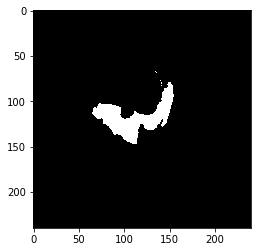

In [ ]:
import matplotlib.pyplot as plt
img = (read_img(seg[0])[100] == 2).astype(np.uint8)
print(img.shape)
print(np.unique(img))
print(img.sum())
plt.imshow(img, cmap='Greys_r')

After resizing to (80, 96, 64)

(96, 64)
[0 1]
116


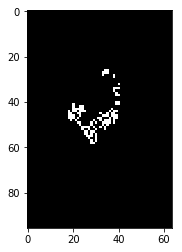

In [ ]:
img = preprocess_label(read_img(seg[0]), out_shape=(80, 96, 64), mode='nearest')[1][50]
print(img.shape)
print(np.unique(img))
print(img.sum())
plt.imshow(img, cmap='Greys_r')

One can clearly notice that there are now a lot of black pixels in the region where there should have been only white pixels. This can potentially hurt our model. So, it is best to not resize the image too much. But, due to computational constraints and the model requirements, it is unavoidable.

However, given below are a few things one could try to reduce the downsampling noise as much as possible.

In [ ]:
import cv2

- Original Image > preprocess_label > Morphological Closing

[0 1]
491


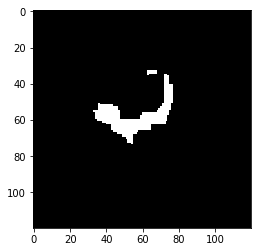

In [ ]:
kernel = np.ones((3, 3))
img_closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
print(np.unique(img_closed))
print(img_closed.sum())
plt.imshow(img_closed, cmap='Greys_r')

- Original Image > preprocess_label > Morphological Dilation

[0 1]
660


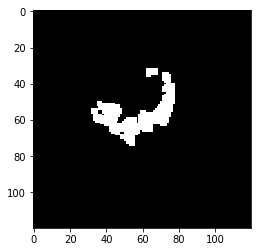

In [ ]:
kernel = np.ones((3, 3))
img_dilated = cv2.dilate(img, kernel, iterations=1)
print(np.unique(img_dilated))
print(img_dilated.sum())
plt.imshow(img_dilated, cmap='Greys_r')

You could try these things to get even better results.

## Feedback

If you have any feedback, queries, bug reports to send, please feel free to [raise an issue](https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/issues/new) on github. It would be really helpful!